## Setting

### Optional

In [1]:
!pip install xgboost lightgbm catboost -U

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
root = "/content/drive/MyDrive/3-2 기계학습/team project/"
import sys
sys.path.append(root)

### Required

In [4]:
from open.train_tuning import Model
from open.evaluation import show_confusion_matrix, show_roc_curve, show_pr_curve, show_prediction_score

is_binary = True

In [5]:
model_type = "xgb"
param_grid = {
    "max_depth": [10, 50, 100, 150],
    "learning_rate": [0.5, 0.1, 0.05, 0.01]
}
selected_features = ['mean_iat', 'std_iat', 'median_iat', 'q25_iat', 'q75_iat', 'ratio_out',
       'switch_count', 'duration', 'n_packets', 'burst_count', 'burst_mean',
       'burst_std', 'burst_max', 'burst_ratio_in', 'num_in', 'num_out',
       'frac_in', 'in_first30', 'out_first30', 'mean_iat_first30',
       'std_iat_first30', 'median_iat_first30', 'q25_iat_first30',
       'q75_iat_first30', 'ratio_out_first30', 'switch_count_first30',
       'duration_first30', 'burst_count_first30', 'burst_mean_first30',
       'burst_std_first30', 'burst_max_first30', 'burst_ratio_in_first30',
       'frac_in_first30'] # fixed

## Loading Data

In [6]:
import pickle
import pandas as pd
import numpy as np

use_original_data = False

# Load the pickle file
print("Loading datafile...")
with open(f"{root}data/preprocess_data_33/open_train_33.pkl", "rb") as f:
    train = pickle.load(f)
    X_train = pd.DataFrame(train["X"])
    X_train.columns = train["feature_names"]
    y_train = train["y_binary"]
    y_train = np.where(y_train == -1, 0, y_train)

with open(f"{root}data/preprocess_data_33/open_val_33.pkl", "rb") as f:
    val = pickle.load(f)
    X_val = pd.DataFrame(val["X"])
    X_val.columns = val["feature_names"]
    y_val = val["y_binary"]
    y_val = np.where(y_val == -1, 0, y_val)

if use_original_data:
  X_train = train['scaler'].inverse_transform(train['X'])
  X_train = pd.DataFrame(X_train)
  X_train.columns = train['feature_names']

  X_val = val['scaler'].inverse_transform(val['X'])
  X_val = pd.DataFrame(X_val)
  X_val.columns = val['feature_names']

print("Loading complete.")
print("Training data size:\t", len(X_train))
print("Validation data size:\t", len(X_val))

Loading datafile...
Loading complete.
Training data size:	 20300
Validation data size:	 4350


In [7]:
# feature selection
def feature_selection(X, selected_features):
  return X[selected_features]

X_train = feature_selection(X_train, selected_features)
X_val = feature_selection(X_val, selected_features)

## Model

### Base Model Training

In [8]:
model = Model(is_binary=is_binary)
# change the model type and parameters accordingly
model.create_model(model_type, n_estimators = 2)
print(model.hparams)
model.fit(X_train, y_train)

{'num_parallel_tree': 2, 'max_depth': 6, 'learning_rate': 0.3, 'subsample': 1, 'colsample_bytree': 1}


In [9]:
y_test_pred = model.predict(X_val)
y_test_pred

array([1, 1, 1, ..., 0, 0, 0])

In [10]:
model.score(X_val, y_val)

0.9294252873563218

In [11]:
_ = model.k_fold_cv(X_train, y_train, k = 5)

5-fold Cross Validation Scores:	[0.92389163 0.92660099 0.93275862 0.92586207 0.92783251]
5-fold Cross Validation Average Score:	0.9273891625615762


### Feature Evaluation

In [12]:
model.get_feature_importances()

{np.str_('switch_count_first30'): 0.20108483731746674,
 np.str_('burst_max_first30'): 0.11838120967149734,
 np.str_('in_first30'): 0.10762916505336761,
 np.str_('burst_std_first30'): 0.0710669457912445,
 np.str_('burst_ratio_in_first30'): 0.05573791265487671,
 np.str_('std_iat_first30'): 0.04154650866985321,
 np.str_('mean_iat_first30'): 0.04139721393585205,
 np.str_('duration'): 0.03865588828921318,
 np.str_('burst_mean'): 0.029818957671523094,
 np.str_('n_packets'): 0.02795904502272606,
 np.str_('burst_ratio_in'): 0.026170849800109863,
 np.str_('frac_in'): 0.026009492576122284,
 np.str_('num_out'): 0.024334382265806198,
 np.str_('switch_count'): 0.02407243102788925,
 np.str_('q75_iat_first30'): 0.023691074922680855,
 np.str_('ratio_out'): 0.022577427327632904,
 np.str_('num_in'): 0.021861596032977104,
 np.str_('mean_iat'): 0.02089359052479267,
 np.str_('std_iat'): 0.019029513001441956,
 np.str_('burst_max'): 0.01741982065141201,
 np.str_('q75_iat'): 0.014550917781889439,
 np.str_('bu

### Hyperparameter Tuning

In [13]:
# define parameter search space
bst = model.grid_search(X_train, y_train, param_grid)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ...learning_rate=0.5, max_depth=10;, score=0.929 total time=   5.5s
[CV 2/5] END ...learning_rate=0.5, max_depth=10;, score=0.930 total time=   2.9s
[CV 3/5] END ...learning_rate=0.5, max_depth=10;, score=0.937 total time=   3.4s
[CV 4/5] END ...learning_rate=0.5, max_depth=10;, score=0.931 total time=   3.0s
[CV 5/5] END ...learning_rate=0.5, max_depth=10;, score=0.933 total time=   5.2s
[CV 1/5] END ...learning_rate=0.5, max_depth=50;, score=0.925 total time=   3.8s
[CV 2/5] END ...learning_rate=0.5, max_depth=50;, score=0.926 total time=   3.7s
[CV 3/5] END ...learning_rate=0.5, max_depth=50;, score=0.933 total time=   6.6s
[CV 4/5] END ...learning_rate=0.5, max_depth=50;, score=0.930 total time=   3.8s
[CV 5/5] END ...learning_rate=0.5, max_depth=50;, score=0.933 total time=   3.8s
[CV 1/5] END ..learning_rate=0.5, max_depth=100;, score=0.925 total time=   6.4s
[CV 2/5] END ..learning_rate=0.5, max_depth=100;

### Evaluation

In [14]:
y = y_val
y_pred = bst.predict(X_val)
y_prob = bst.predict_proba(X_val)[:, 1]

1. Confusion Matrix

              precision    recall  f1-score   support

 unmonitored       0.91      0.89      0.90      1500
   monitored       0.94      0.95      0.95      2850

    accuracy                           0.93      4350
   macro avg       0.93      0.92      0.92      4350
weighted avg       0.93      0.93      0.93      4350



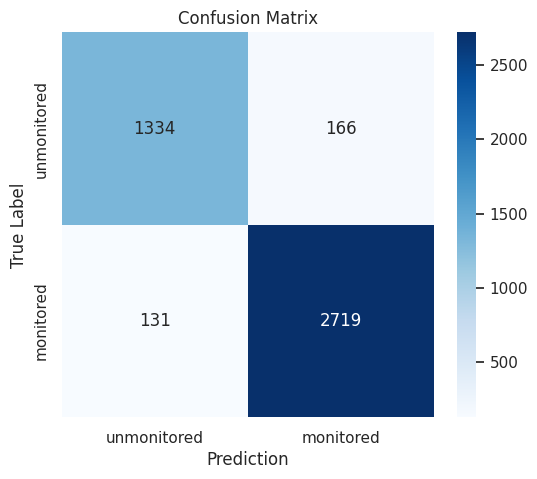

In [15]:
show_confusion_matrix(y, y_pred, model_type)

2. ROC Curve

- ROC AUC Score: 0.9816


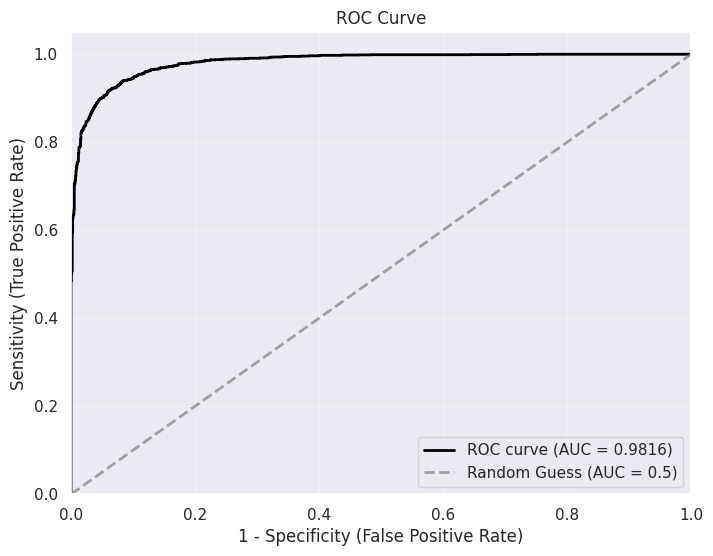

In [16]:
show_roc_curve(y, y_prob, model_type)

3. PR Curve

- Average Precision (AP) Score: 0.9902


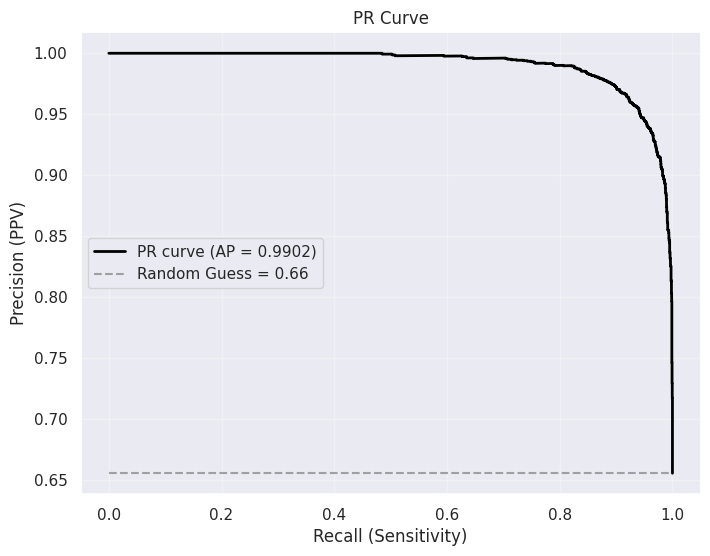

In [17]:
show_pr_curve(y, y_prob, model_type)

4. Prediction Score


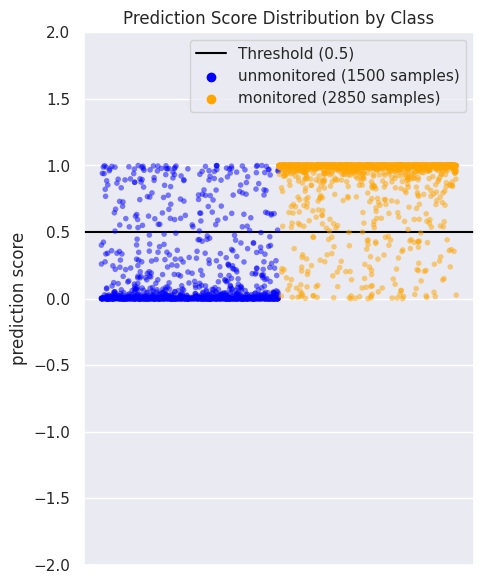

In [18]:
show_prediction_score(y, y_prob, model_type)

### Save Model

In [19]:
model.save_model(model=bst.best_estimator_, file_name=f"{bst.best_params_}")